In [2]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Replace with the GPU index you want to use

# Confirm the selected GPU
print(f"Using GPU {os.environ['CUDA_VISIBLE_DEVICES']} for the experiment.")

Using GPU 0 for the experiment.


In [3]:
#imports
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy
import seaborn as sns
import math
import json
import tensorflow as tf
import keras as keras
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

2024-01-07 16:28:19.492245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import keras
print(keras.__version__)

2.13.1


In [5]:
print(tf.__version__)

2.13.0


In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Print the list of available GPUs
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPU available.")

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [8]:
#Prepare Training Data:
path_to_X = "../Normalised/X.npy"
path_to_Y = "../Normalised/Y.npy"
X = np.load(path_to_X)
Y = np.load(path_to_Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
print(len(X_train))
print(len(X_test))
# Reshape the input and output data for the encoder and decoder
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # (No of Data, 50) to (No of data, 50,1)
print("X_train_reshaped shape: ", X_train_reshaped.shape)
Y_train_reshaped = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
print("Y_train_resahped shape: ", Y_train_reshaped.shape)
# Define the input shape for the encoder
input_shape = X_train_reshaped.shape[1:]  # Shape: (sequence_length, 1) # 50,1
print("Input_shape: ", input_shape)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test_reshaped = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)
print("X_test_reshaped",X_test_reshaped.shape)
print("Y_test_reshaped",Y_test_reshaped.shape)

49730
12433
X_train_reshaped shape:  (49730, 50, 1)
Y_train_resahped shape:  (49730, 81, 1)
Input_shape:  (50, 1)
X_test_reshaped (12433, 50, 1)
Y_test_reshaped (12433, 81, 1)


In [9]:
# Define the model
def createModel(units, optimizer):        
    # Define the encoder
    encoder_inputs = Input(shape=input_shape)
    encoder_lstm = LSTM(units)(encoder_inputs)
    encoder_model = Model(encoder_inputs, encoder_lstm)
    
    # Define the input shape for the decoder (with 40 units to match encoder LSTM units)
    decoder_inputs = Input(shape=(units,))  # This will serve as the initial state of the decoder LSTM
    decoder_lstm = LSTM(units, return_sequences=True)(RepeatVector(Y_train_reshaped.shape[1])(decoder_inputs))
    decoder_outputs = Dense(1, activation='sigmoid')(decoder_lstm)
    
    # Define the decoder model
    decoder_model = Model(decoder_inputs, decoder_outputs)
    
    # Create the full seq_model model
    seq_model_outputs = decoder_model(encoder_lstm)
    seq_model = Model(encoder_inputs, seq_model_outputs)
    
    # Compile the model
    seq_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics = ['mae'])
    
    # Display the model summary
    seq_model.summary()
    return seq_model

In [10]:
#Train the model
# Enable logging of device placement
tf.debugging.set_log_device_placement(False)

# Verify the available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs:", gpus)
if gpus:
    # Use the first GPU for training
    with tf.device('/GPU:0'):
        seq_model = createModel(32,'adam')
        save_path = "./Saved_Models_Data/P20_U32_OA/"
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
        print("EarlyStopping Set")
        mc = ModelCheckpoint("./Saved_Models_Data/P20_U32_OA/best_enc_dec_3.h5", monitor = 'val_loss',mode='min', save_best_only=True, verbose=1)
        print("MC set")
        history = seq_model.fit(X_train_reshaped, Y_train_reshaped, batch_size=32, epochs=200, validation_split=0.2, callbacks=[early_stopping, mc])
        with open(save_path+'history_3.json','w') as file:
            json.dump(history.history, file)
else:
    print("No GPU available.")

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-07 16:28:46.773491: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78946 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 model_1 (Functional)        (None, 81, 1)             8353      
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (49.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
EarlyStopping Set
MC set
Epoch 1/200


2024-01-07 16:29:02.228811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-07 16:29:02.366800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-07 16:29:02.367280: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef62c03f1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-07 16:29:02.367300: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-01-07 16:29:02.372087: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-07 16:29:02.480025: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

1244/1244 [==============================] - ETA: 0s - loss: 0.1143 - mae: 0.2373
Epoch 1: val_loss improved from inf to 0.09604, saving model to ./Saved_Models_Data/P20_U32_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 17s 11ms/step - loss: 0.1143 - mae: 0.2373 - val_loss: 0.0960 - val_mae: 0.2081
Epoch 2/200
  16/1244 [..............................] - ETA: 12s - loss: 0.1001 - mae: 0.2100

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1243/1244 [============================>.] - ETA: 0s - loss: 0.0858 - mae: 0.1824
Epoch 2: val_loss improved from 0.09604 to 0.07980, saving model to ./Saved_Models_Data/P20_U32_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 14s 11ms/step - loss: 0.0858 - mae: 0.1824 - val_loss: 0.0798 - val_mae: 0.1634
Epoch 3/200
1243/1244 [============================>.] - ETA: 0s - loss: 0.0790 - mae: 0.1593
Epoch 3: val_loss improved from 0.07980 to 0.07749, saving model to ./Saved_Models_Data/P20_U32_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 14s 11ms/step - loss: 0.0790 - mae: 0.1593 - val_loss: 0.0775 - val_mae: 0.1555
Epoch 4/200
1242/1244 [============================>.] - ETA: 0s - loss: 0.0744 - mae: 0.1469
Epoch 4: val_loss improved from 0.07749 to 0.07201, saving model to ./Saved_Models_Data/P20_U32_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 14s 11ms/step - loss: 0.0744 - mae: 0.1469 - val_loss: 0.0720 - val_mae: 0.1424
Epoc

In [11]:
#plot the loss training history

save_path = "./Saved_Models_Data/P20_U32_OA/"
f = open(save_path+"history_3.json")
history = json.load(f)

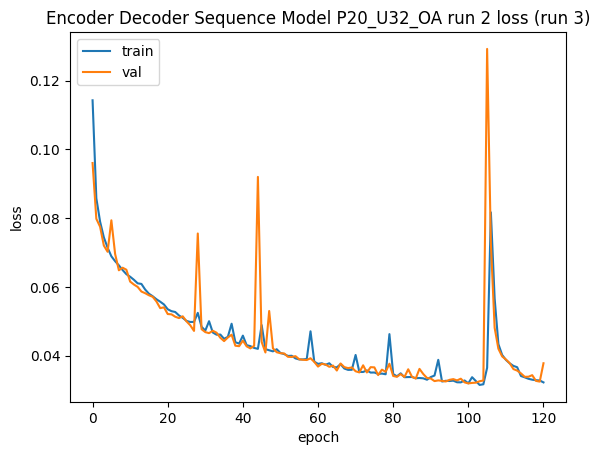

In [12]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Encoder Decoder Sequence Model P20_U32_OA run 2 loss (run 3)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
#Evaluate the saved best model:
from tensorflow.keras.models import load_model
saved_model = load_model("./Saved_Models_Data/P20_U32_OA/best_enc_dec_3.h5")
best_eval = saved_model.evaluate(X_test_reshaped, Y_test_reshaped)

print("Mean Squared Error: ", best_eval[0])
print("Mean Absolute Error: ", best_eval[1])

#RMSE:
mse_value = best_eval[0]
rmse_value = np.sqrt(mse_value)
print("Root Mean Squared Error (RMSE): ", rmse_value)

389/389 [==============================] - 3s 5ms/step - loss: 0.0320 - mae: 0.0617
Mean Squared Error:  0.03195321187376976
Mean Absolute Error:  0.06172086298465729
Root Mean Squared Error (RMSE):  0.1787546135733838


In [14]:
save_path = "./Saved_Models_Data/P20_U32_OA/"

In [15]:
#Save the predictions
predictions = saved_model.predict(X_test_reshaped)
original_shape_predictions = predictions.reshape(X_test.shape[0], Y_test.shape[1])
np.save(save_path+"predictions_3.npy",original_shape_predictions)

#Save the ground truth:
np.save(save_path+"ground-truth_3.npy", Y_test)

389/389 [==============================] - 2s 4ms/step


In [16]:
#Print some samples:
for sample in range(5):
  print(f"SAMPLE: {sample}")
  for i in range (81):
    print(f"Index {i} Ground truth: {Y_test[sample][i]} Predicted: {original_shape_predictions[sample][i]}")

SAMPLE: 0
Index 0 Ground truth: 0 Predicted: 0.013531416654586792
Index 1 Ground truth: 0 Predicted: 0.29569941759109497
Index 2 Ground truth: 1 Predicted: 0.6441529393196106
Index 3 Ground truth: 0 Predicted: 0.002833734033629298
Index 4 Ground truth: 0 Predicted: 0.0007576317875646055
Index 5 Ground truth: 0 Predicted: 0.000411629443988204
Index 6 Ground truth: 0 Predicted: 1.3568816939368844e-05
Index 7 Ground truth: 0 Predicted: 1.9774904558289563e-07
Index 8 Ground truth: 0 Predicted: 6.9249757837785975e-12
Index 9 Ground truth: 0 Predicted: 2.569650628348949e-14
Index 10 Ground truth: 0 Predicted: 8.422519544868182e-15
Index 11 Ground truth: 0 Predicted: 4.7084914092665464e-12
Index 12 Ground truth: 0 Predicted: 0.0016801065066829324
Index 13 Ground truth: 1 Predicted: 0.9862057566642761
Index 14 Ground truth: 0 Predicted: 0.0027766122948378325
Index 15 Ground truth: 0 Predicted: 1.0111652954947203e-06
Index 16 Ground truth: 0 Predicted: 0.00011136896500829607
Index 17 Ground tru

In [17]:
#Can convert to Benesh version for predictions using a threshold here
#Can convert to Benesh version for predictions using a threshold here
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path+"ground-truth_3.npy")
print("Converting the predictions to benesh versions:")
benesh_arr = np.zeros_like(y_pred)

for sample in range(len(y_pred)):
  #print(f"SAMPLE: {sample}")
  for i in range (81):
    # can add more logic here to change the thresholds for specific indices.
    if y_pred[sample][i] >= 0.5:
      benesh_arr[sample][i] = 1
    elif y_pred[sample][i] < 0.5:
      benesh_arr[sample][i]= 0

print(benesh_arr[:2])
np.save(save_path+"y_pred_benesh_3.npy", benesh_arr)

Converting the predictions to benesh versions:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]]


In [18]:
#save the error array
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path+"ground-truth_3.npy")

err_arr = np.zeros((12433,81))

for r in range(len(y_pred)):
    for c in range(81):
        err_arr[r][c] = abs(y_true[r][c]-y_pred[r][c])
        
np.save(save_path+"err_arr_3.npy",err_arr)

In [19]:
# import pandas as pd
# err_arr = np.load(save_path+"err_arr.npy")
# cols = [i for i in range(0, 81)]
# df = pd.DataFrame(err_arr, columns = cols)
# print(df.iloc[:2])

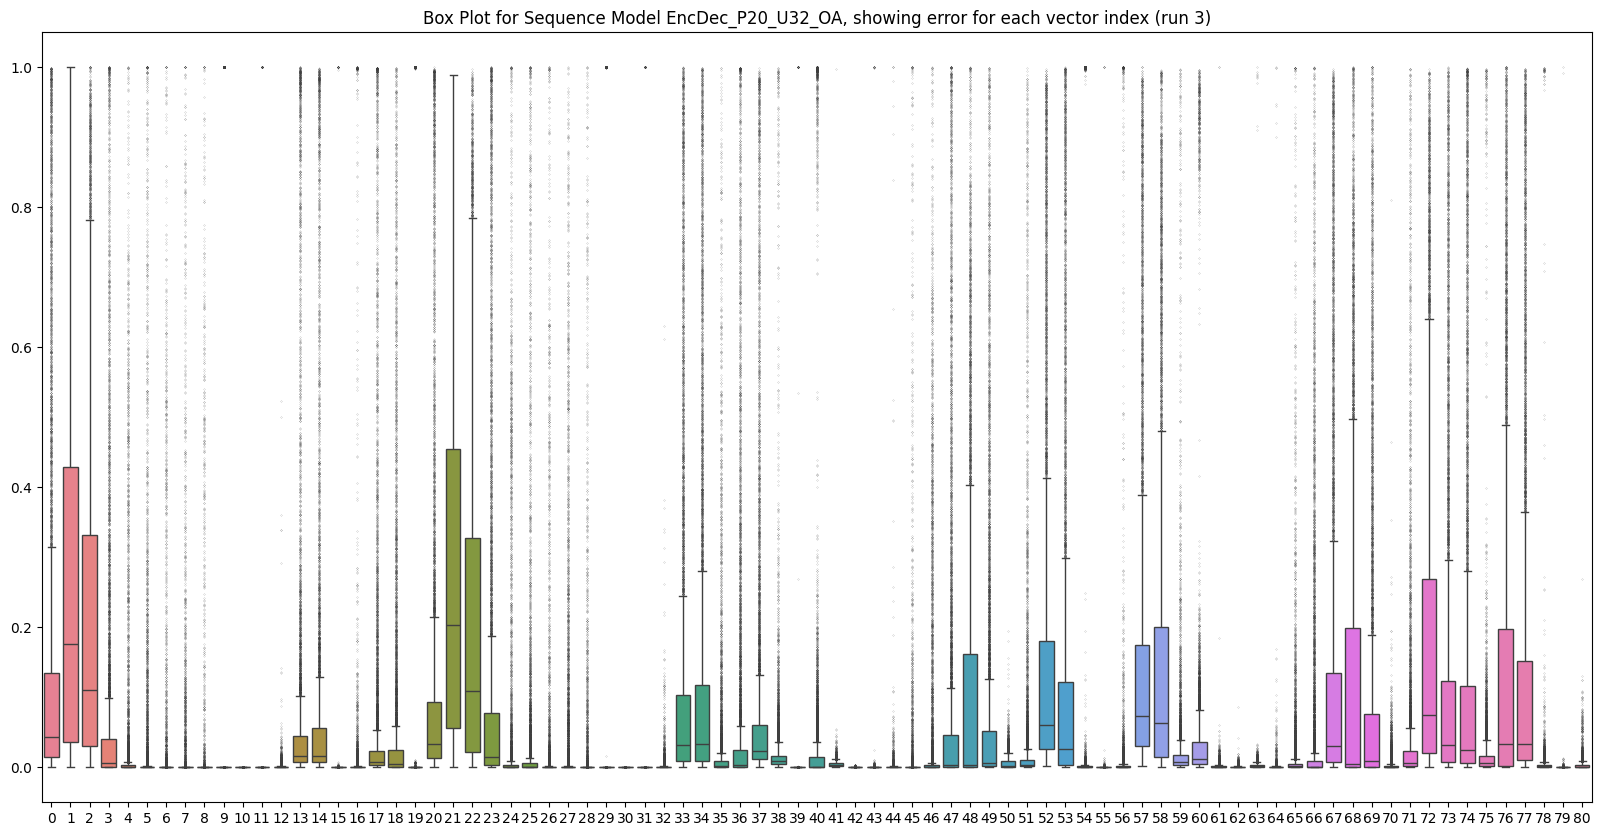

In [20]:
err_arr = np.load(save_path+"err_arr_3.npy")
#fig, ax = plt.subplots(figsize=(18, 9))
plt.figure(figsize = (20,10))
sns.boxplot(err_arr, fliersize = 0.1 ,gap=0.05).set(title='Box Plot for Sequence Model EncDec_P20_U32_OA, showing error for each vector index (run 3)')
plt.show()

In [29]:
#Calculate MAPE:
#Manual calculation:
def mean_abs_perc_err(gt_arr, pred_arr, num_samples, vec_size):
    err_arr = np.zeros((num_samples,vec_size))
    print("Calculating MAPE")
    for r in range(len(pred_arr)):
        for c in range(vec_size):
          err_arr[r][c] = abs(gt_arr[r][c]-pred_arr[r][c]) # Calculation of the percentage error
    per_sample_mape_arr = np.sum(err_arr,axis=1)/vec_size
    print(per_sample_mape_arr.shape)
    print("MAPE for 10 samples...",per_sample_mape_arr[:10])
    overall_MAPE = sum(per_sample_mape_arr)/num_samples
    print("OVERALL MAPE: ", overall_MAPE*100) #* by 100 in results

n_samples = 12433
v_size = 81
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path+"ground-truth_3.npy")
mean_abs_perc_err(y_true,y_pred,n_samples,v_size)

Calculating MAPE
(12433,)
MAPE for 10 samples... [0.05825421 0.06135687 0.04442074 0.06133084 0.05706011 0.04772829
 0.09337632 0.09987109 0.05202962 0.05140981]
OVERALL MAPE:  6.172089035688698


In [22]:
from sklearn.metrics import r2_score

In [23]:
#Calculate R2 Score:
result_r2 = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the R-squared value for each row
    r2 = r2_score(y_true[i, :], y_pred[i, :])
    result_r2[i] = r2

print("R-squared value for each row (sample):", result_r2)
# Calculate the overall R-squared value
overall_r2 = np.mean(result_r2)

# Print the overall R-squared value
print("Overall R-squared value:", overall_r2)

R-squared value for each row (sample): [0.85133718 0.70143179 0.90314234 ... 0.80355614 0.75714068 0.77306492]
Overall R-squared value: 0.7468055360416695


In [24]:
#Spearman Correlation:
result = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Spearman correlation for each row
    row_result = scipy.stats.spearmanr(y_true[i, :], y_pred[i, :])

    # Checking for zero standard deviation
    if np.isnan(row_result.correlation) or np.isnan(row_result.pvalue):
        # Handle the case where the result contains NaN
        result[i] = 0  # Set the correlation coefficient to 0
    else:
        result[i] = row_result.correlation

print("Spearman correlation coefficients for each row (sample):", result)
overall_spearman_corr = np.mean(result)

# Print the overall Spearman correlation coefficient
print("Overall Spearman correlation coefficient:", overall_spearman_corr)

Spearman correlation coefficients for each row (sample): [0.61089329 0.59305699 0.61535237 ... 0.58859792 0.60494786 0.53806173]
Overall Spearman correlation coefficient: 0.5798317149667366


In [25]:
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path+"ground-truth_3.npy")

In [26]:
#Pearson Correlation:
result_pearson = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Pearson correlation for each row
    corr_matrix = np.corrcoef(y_true[i, :], y_pred[i, :])
    result_pearson[i] = corr_matrix[0, 1]

# Calculate the overall Pearson correlation coefficient
overall_pearson_corr = np.mean(result_pearson)

print("Pearson correlation coefficients for each row:", result_pearson)
print(len(result_pearson))
# Print the overall Pearson correlation coefficient
print("Overall Pearson correlation coefficient:", overall_pearson_corr)

Pearson correlation coefficients for each row: [0.92818094 0.83941986 0.95485267 ... 0.89721069 0.8703905  0.87984901]
12433
Overall Pearson correlation coefficient: 0.8621395900495453


In [27]:
#MCC: continuous y_pred values converted to BENESH 0.5 threshold:
from sklearn.metrics import matthews_corrcoef
y_pred = np.load(save_path + "y_pred_benesh_3.npy")
y_true = np.load(save_path + "ground-truth_3.npy")

result_mcc = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Matthews Correlation Coefficient for each row
    mcc = matthews_corrcoef(y_true[i, :], y_pred[i, :])
    result_mcc[i] = mcc

# Calculate the overall Matthews Correlation Coefficient
overall_mcc = np.mean(result_mcc)

# Print the overall Matthews Correlation Coefficient
print("Overall Matthews Correlation Coefficient:", overall_mcc)

Overall Matthews Correlation Coefficient: 0.8288233447736592


In [28]:
#Save boxplot stats
import numpy as np
save_path = "./Saved_Models_Data/P20_U32_OA/"

np.set_printoptions(suppress=True) # Disable scientific notation
filename = "err_arr_3.npy"

err = np.load(save_path+filename)
print(len(err))

stats = np.empty(shape = (0,5))
n_indices = len(err[0]) # should be 81
print(n_indices)

for i in range(n_indices):
    i_stats = np.percentile(err[:, i], [0, 25, 50, 75, 100]) # = [Min, Q1, Med, Q3, Max]
    stats = np.vstack([stats, i_stats]) # Add row to numpy stats object 
    print("index: {}".format(i), i_stats)

# print(stats)
out_filename = "boxplot_stats_3.csv"

np.savetxt(save_path+out_filename, stats, delimiter = ',', fmt='%f')


12433
81
index: 0 [0.00018165 0.01453207 0.04275367 0.13480686 0.99947918]
index: 1 [0.00000021 0.03657088 0.17628594 0.42843351 0.99998346]
index: 2 [0.00000003 0.03022254 0.11057585 0.33121827 0.9999998 ]
index: 3 [0.00000003 0.00058408 0.00549059 0.03994976 0.99995944]
index: 4 [0.00000001 0.00006479 0.00032817 0.00282281 0.99998374]
index: 5 [0.00000006 0.00000892 0.00006024 0.00099156 0.99999969]
index: 6 [0.00000005 0.00000069 0.00000309 0.00003255 0.99999989]
index: 7 [0.         0.00000008 0.00000019 0.00000086 0.99999985]
index: 8 [0. 0. 0. 0. 1.]
index: 9 [0. 0. 0. 0. 1.]
index: 10 [0.         0.         0.         0.         0.00000124]
index: 11 [0. 0. 0. 0. 1.]
index: 12 [0.00000001 0.00001787 0.00012224 0.00060878 0.52287793]
index: 13 [0.00002206 0.00727671 0.01611656 0.04529792 0.99993272]
index: 14 [0.00002667 0.00688471 0.01588789 0.0555343  0.99943636]
index: 15 [0.00000003 0.00000083 0.00000367 0.0000203  0.99999977]
index: 16 [0.00000066 0.00003094 0.00013794 0.000